In [1]:
import pickle
import numpy as np 
import pandas as pd 

from sklearn.metrics import silhouette_score

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [2]:
exp = 'exp1'
trials = [0, 10, 20, 30, 59]
dpi = 300
to_pdf = True

In [3]:
def analyze_ecPG(trials, lmbdas=[0, .05, .1, .2, .5]):
    all_sim_data = []
    all_gen_data = []
    for lmbda in lmbdas:
        
        # transfer performance
        fname = f'../simulations/exp1/ecPG_sim/simsubj-cont_data-'
        fname += f'alpha_psi=40-alpha_rho=8-lmbda={lmbda}.csv'
        sim_data = pd.read_csv(fname)
        gen_data = sim_data.query('stage=="test"').copy()
        gen_data['lmbda'] = str(lmbda)
        all_gen_data.append(gen_data)

        # complexity 
        sel_data = sim_data.query('stage=="train"').groupby(by=['trial']
                        ).mean(numeric_only=True).reset_index()
        sel_data['i_SZ'] = sel_data['i_SZ'].apply(lambda x: x/np.log(2))
        sel_data['lmbda'] = str(lmbda)
        
        # clustering
        fname = f'../simulations/exp1/ecPG_sim/simsubj-cont_voi-'
        fname += f'alpha_psi=40-alpha_rho=8-lmbda={lmbda}.pkl'
        with open(fname, 'rb')as handle:
            voi = pickle.load(handle)
        cluster_score = []
        lbl = [0, 0, 1, 1]
        for i in range(len(voi['enc'])):
            x = voi['enc'][i]
            cluster_score.append(silhouette_score(x, lbl))
        
        # combine 
        sel_data['clusters'] = cluster_score
        all_sim_data.append(sel_data)
    all_sim_data = pd.concat(all_sim_data, axis=0)
    all_gen_data = pd.concat(all_gen_data, axis=0).groupby(
        by=['lmbda', 'untrained'])['r'].mean().reset_index()
    fig, axs = plt.subplots(1, 3, figsize=(13, 3.3))
    ax=axs[2]
    sns.barplot(x='untrained', y='r', data=all_gen_data,
                lw=.5, edgecolor=viz.lmbda_gradient[4],
                #legend=False,
                hue='lmbda',
                palette=viz.lmbda_gradient,
                alpha=.8,
                ax=ax)
    ax.legend().remove()
    ax.axhline(y=.5, xmin=0, xmax=1, ls='--', lw=1, color='k')
    for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.75)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Trained', 'Untrained'])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('')
    ax.set_box_aspect(.85)
    ax=axs[0]
    sns.lineplot(x='trial', y='i_SZ', data=all_sim_data,
                lw=6,
                legend=False,
                hue='lmbda',
                palette=viz.lmbda_gradient,
                alpha=.8,
                ax=ax)
    sns.lineplot(x='trial', y='i_SZ', data=all_sim_data.query(f'lmbda=="0.1"'),
                lw=8,
                legend=False,
                #hue='lmbda',
                color=viz.lmbda_gradient[2],
                alpha=.8,
                ax=ax)
    for t in trials:
        row = all_sim_data.query(f'lmbda=="0.1"&trial=={t}')
        xr = row['trial'].values[0]
        yr = row['i_SZ'].values[0]
        ax.scatter(xr, yr, marker='x', color='k', s=200, zorder=10)
        # ax.text(xr-4, yr+.12, f't={t}', 
        #             horizontalalignment='left', fontsize=16,
        #             color='k', zorder=100)
    for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.75)
    ax.set_xticks([0, 30, 60])
    ax.set_ylabel('Represenation \ncomplexity (bits)')
    ax.set_xlabel('Trials')
    ax.set_box_aspect(.85)
    ax=axs[1]
    sns.lineplot(x='trial', y='clusters', data=all_sim_data,
                lw=6,
                legend=False,
                hue='lmbda',
                palette=viz.lmbda_gradient,
                alpha=.8,
                ax=ax)
    sns.lineplot(x='trial', y='clusters', data=all_sim_data.query(f'lmbda=="0.1"'),
                lw=8,
                legend=False,
                #hue='lmbda',
                color=viz.lmbda_gradient[2],
                alpha=.8,
                ax=ax)
    for t in trials:
        row = all_sim_data.query(f'lmbda=="0.1"&trial=={t}')
        xr = row['trial'].values[0]
        yr = row['clusters'].values[0]
        ax.scatter(xr, yr, marker='x', color='k', s=200, zorder=10)
    ax.set_xticks([0, 30, 60])
    for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.75)
    fig.tight_layout()
    ax.set_ylabel('Degree of \nabstraction (a.u.)')
    ax.set_xlabel('Trials')
    ax.set_box_aspect(.9)

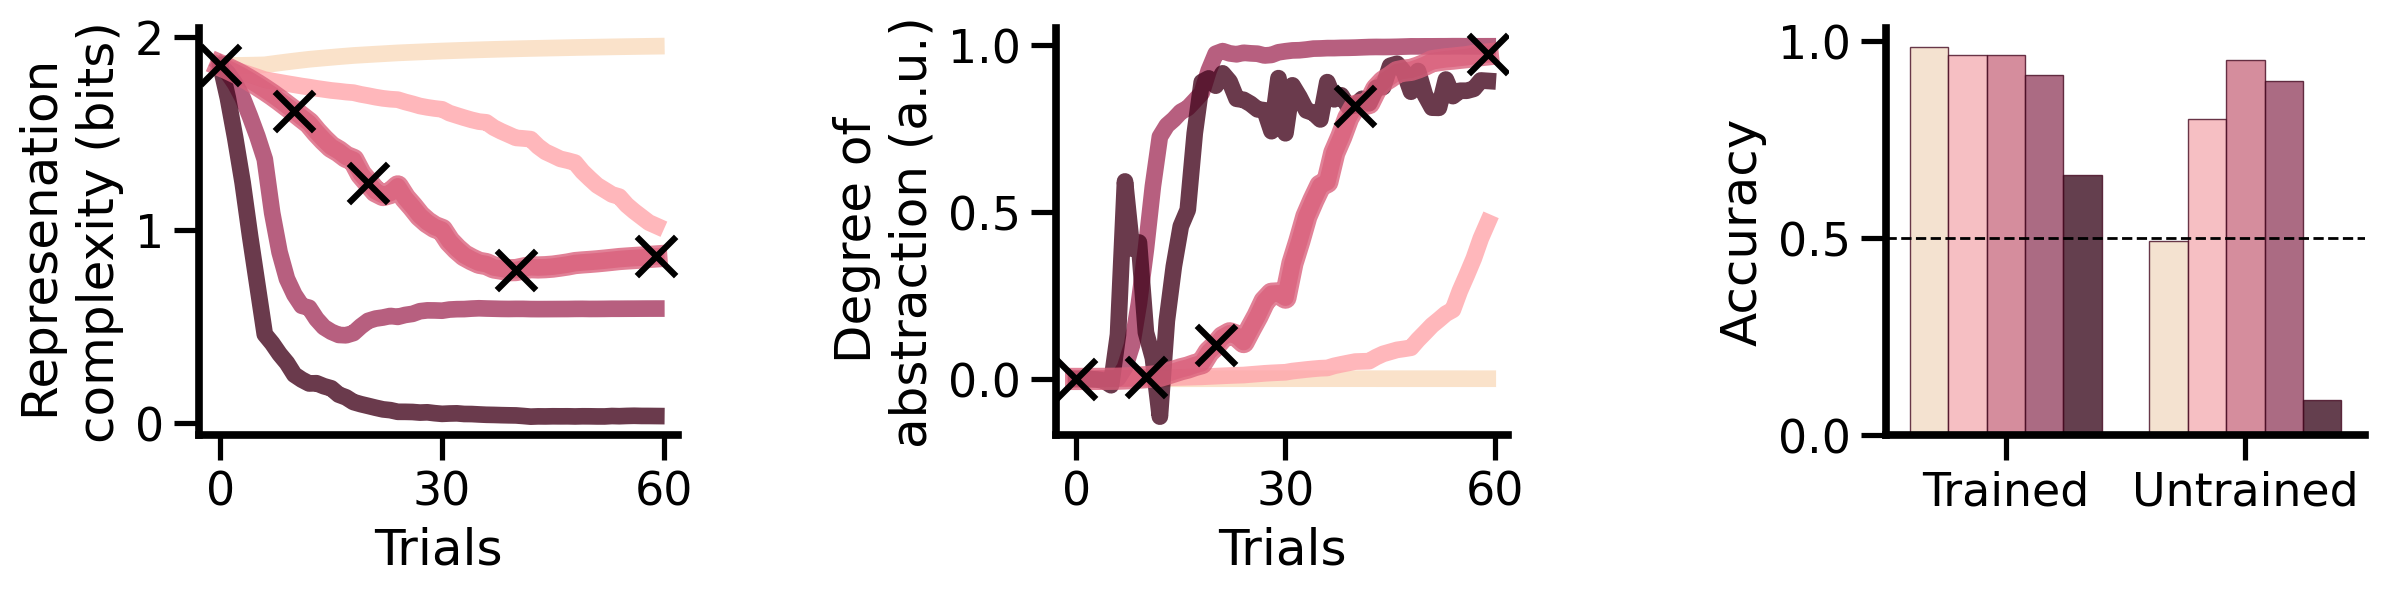

In [4]:
trials = [0, 10, 20, 40, 59]
analyze_ecPG(trials=trials, lmbdas=[0, .07, .1, .2, .5])
if to_pdf: plt.savefig(f'../figures/{exp}/Fig3ABC_simulations.pdf', dpi=dpi) 


In [5]:
lmbda = .1
fname = f'../simulations/exp1/ecPG_sim/simsubj-cont_voi-'
fname += f'alpha_psi=40-alpha_rho=8-lmbda={lmbda}.pkl'
with open(fname, 'rb')as handle:
    voi = pickle.load(handle)
fname = f'../simulations/exp1/ecPG_sim/simsubj-cont_data-'
fname += f'alpha_psi=40-alpha_rho=8-lmbda={lmbda}.csv'
sim_data = pd.read_csv(fname)

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


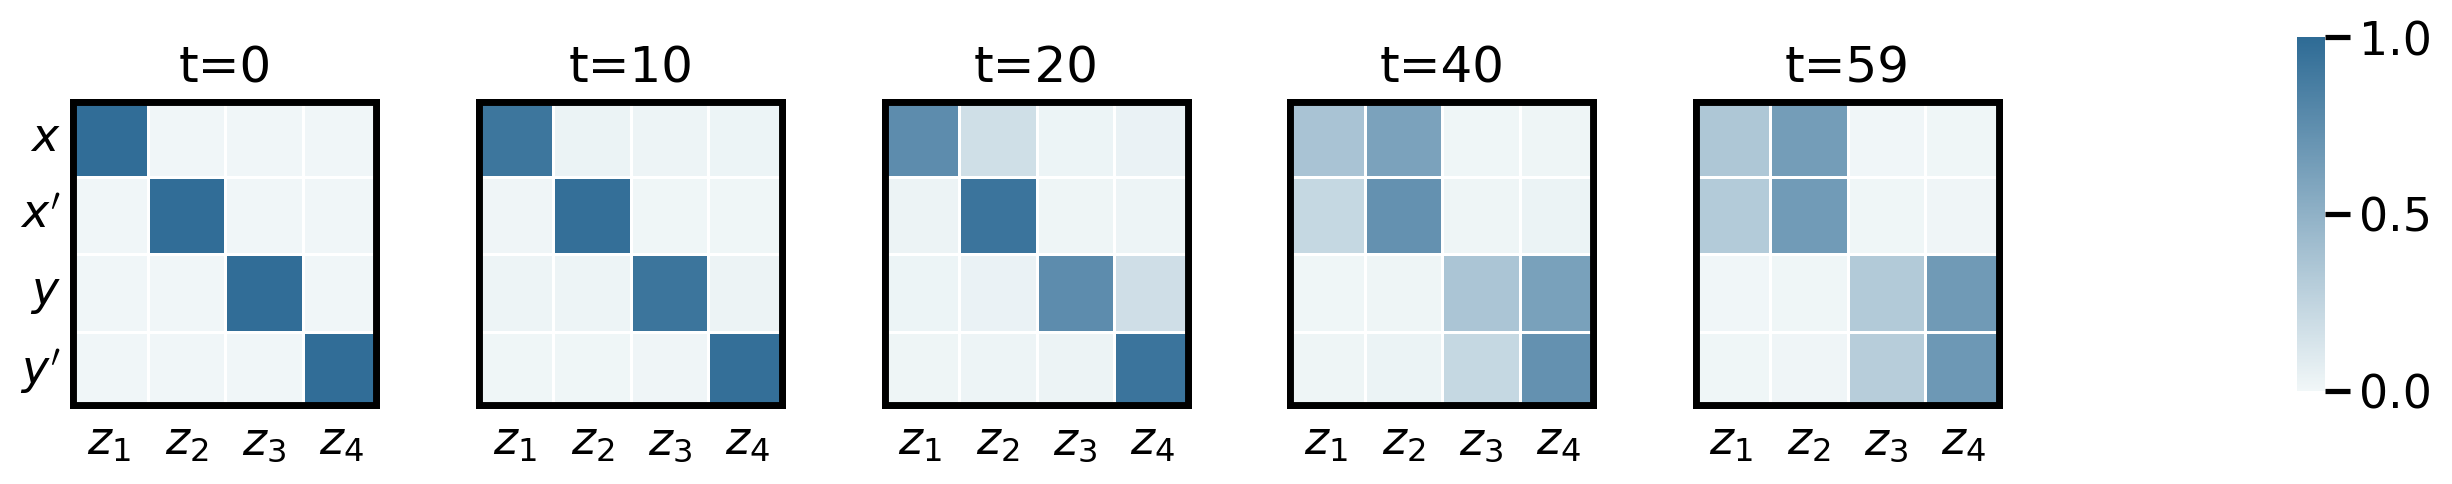

In [6]:
sim_Insight(voi, sim_data, tar='enc', trials=trials)
if to_pdf: plt.savefig(f'../figures/{exp}/Fig3D_encoder.pdf', dpi=dpi) 

In [7]:
if to_pdf: plt.savefig(f'../figures/{exp}/Fig3E_policy.pdf', dpi=dpi) 

<Figure size 640x480 with 0 Axes>

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


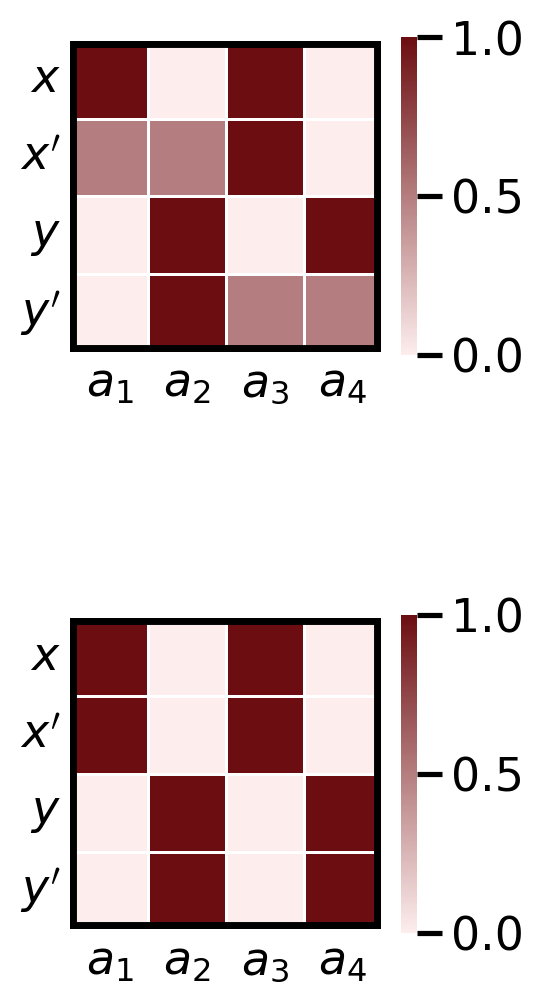

In [8]:
trainInfo() 
if to_pdf: plt.savefig(f'../figures/{exp}/Fig3F_train_info.pdf', dpi=dpi) 